In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Literal
from scipy.optimize import curve_fit

# Evaporation Modeling (Penman's Equation vs. Pan Coefficient)

## Penman's Equation

$$
\begin{aligned}
  & E_0 = (0.015 + 0.00042T + 10^{-6}z) (0.8R_s - 40 + 2.5Fu (T-T_d)) \\
  & \text{$T$ is the daily mean temperature (°C), $z$ is the elevation (m), $R_s$ is the solar irradiance, } \\
  & \text{$F = 1 - 8.7 \cdot 10^-5 z$, $u$ is the windspeed at $2$m, and $T_d$ is the dewpoint temperature (°C).}
\end{aligned}
$$

## Pan Coefficient

$$P = 0.8$$

In [213]:
def get_mean(
    df: pd.DataFrame,
    time_col: str,
    columns: str | list[str],
    interval: Literal["D", "M", "Y"],
) -> pd.DataFrame:
    """
    Returns the daily, monthly, or yearly mean of the given column(s) as a `DataFrame` with additional `day`, `month`, and `year` columns where applicable
    """

    avg_df = pd.DataFrame(
        df.groupby(df[time_col].dt.to_period(interval))[columns].mean()
    )

    avg_df["year"] = avg_df.index.year
    if interval != "Y":
        avg_df["month"] = avg_df.index.month
    if interval == "D":
        avg_df["day"] = avg_df.index.day

    return avg_df


def get_range(
    df: pd.DataFrame,
    time_col: str,
    columns: str | list[str],
    interval: Literal["D", "M", "Y"],
) -> pd.DataFrame:
    """
    Returns the daily, monthly, or yearly range of the given column(s) as a `DataFrame` with additional `day`, `month`, and `year` columns where applicable
    """

    interval_df = pd.DataFrame(
        df.groupby(df[time_col].dt.to_period(interval))[columns].max()
        - df.groupby(df[time_col].dt.to_period(interval))[columns].min()
    )

    interval_df["year"] = interval_df.index.year
    if interval != "Y":
        interval_df["month"] = interval_df.index.month
    if interval == "D":
        interval_df["day"] = interval_df.index.day

    return interval_df


def f_to_c(f: float) -> float:
    return (f - 32) * 5 / 9


def knots_to_mps(knots: float) -> float:
    return knots * 0.514444


def get_evaporation_rate(
    mean_temp: float, dewp_temp: float, elev: float, solar_irr: float, wind_speed: float
) -> float:
    return (0.015 + 0.00042 * mean_temp + 10**-6 * elev) * (
        0.8 * solar_irr
        - 40
        + 2.5 * (1.0 - 8.7 * 10**-5 * elev) * wind_speed * (mean_temp - dewp_temp)
    )

## Iowa Enviromental Mesnoet Data

NOTE: As of 7/14/2023, we're using 0.0001 for trace reports instead of blank/empty values

PGA_2005_2020 is to match with solar radiation data, wich is 01/01/2005 - 12/31/2020

Query details: Arizona ASOS, PAGE MUNI, all data, 01/01/2003 - 01/01/2023, UTC, CSV, no latitude/longitude, no elevation, blank/empty values, Routine & Specials

Exact API query: https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=PGA&data=all&year1=2003&month1=1&day1=1&year2=2023&month2=1&day2=1&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=empty&trace=empty&direct=yes&report_type=3&report_type=4

In [214]:
SURFACE_AREA = 19991.22
ELEVATION = 1815
LATITUDE = 36.33385606273248
CATCHMENT_AREA = 482970.15  # (m^2), from loading GEOJSON to http://geojson.io/

pga_df = pd.read_csv(
    "Water Optimization/dynamics_model/PGA_2005_2020.csv",
    usecols=["valid", "tmpf", "dwpf", "sknt", "p01i"],
    header=0,
    dtype={
        "valid": "string",  # Datetime. Consider "datetime64[ns, UTC]"
        "tmpf": "Float32",  # Temperature (°F)
        "dwpf": "Float32",  # Dewpoint (°F)
        "sknt": "Float32",  # Wind speed (knots)
        "p01i": "Float32",  # Precipitation in last hr (mm)
    },
)

pga_df["valid"] = pd.to_datetime(pga_df["valid"], utc=True)
pga_df["valid"] = pga_df["valid"].dt.tz_localize(None)  # Remove timezone information
pga_df = pga_df.convert_dtypes()

print(f"NaN values:")  # TODO: Consider interpolating
print(pga_df.isna().sum())
pga_df = pga_df.dropna()
print(f"Total values (removed NaN): {pga_df.shape[0]}")


pga_df["tmpc"] = pga_df["tmpf"].apply(f_to_c)
pga_df["dwpc"] = pga_df["dwpf"].apply(f_to_c)
pga_df["smps"] = pga_df["sknt"].apply(knots_to_mps)

pga_df.describe()

# https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg
pan_m_df = pd.DataFrame(
    {
        "month": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "evap": [
            0.00,
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            0.00,
        ],
    }
)

pan_m_df["est"] = (
    0.8 * pan_m_df["evap"] * 25.4 / 30.437
)  # in/month -> mm/day (using approximate mean of days/month)

NaN values:
valid        0
tmpf       137
dwpf       233
sknt      2485
p01i     58517
dtype: int64
Total values (removed NaN): 85370


## Photovoltaic Geographical Information System (PVGIS) Solar Radiation Data

https://re.jrc.ec.europa.eu/pvg_tools/en/

PVGIS-ERA5, 2005-2020, Fixed, 0, 0, no PV, CSV

- G(i): Global irradiance on the inclined plane (plane of the array) (W/m2)
- H_sun: Sun height (degree)
- T2m: 2-m air temperature (degree Celsius)
- WS10m: 10-m total wind speed (m/s)
- Int: 1 means solar radiation values are reconstructed

CSV Header Info: https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/pvgis-tools/hourly-radiation_en

In [215]:
irr_df = pd.read_csv(
    "Water Optimization/dynamics_model/Curve_Radiation_2005_2020.csv",
    usecols=["time", "G(i)", "H_sun", "T2m", "WS10m"],
    header=0,
    dtype={
        "time": "string",  # Datetime. Consider "datetime64[ns, UTC]"
        "G(i)": "Float32",  # Global in-plane irradiance (W / m^2)
        "H_sun": "Float32",  # Sun height (°)
        "T2m": "Float32",  # Air temperature (°C)
        "WS10m": "Float32",  # Wind speed (m/s)
    },
)

# Convert YYYYMMDD:HHMM format to Pandas datetime
irr_df["time"] = pd.to_datetime(
    irr_df["time"].apply(lambda x: x[:4] + "-" + x[4:6] + "-" + x[6:8] + " " + x[9:]),
    utc=True,
)
irr_df["time"] = irr_df["time"].dt.tz_localize(None)  # Remove timezone information
irr_df = irr_df.convert_dtypes()

irr_df.describe()

,G(i),H_sun,T2m,WS10m
count,140256.0,140256.0,140256.0,140256.0
mean,241.109058,16.271824,12.552853,2.21561
std,319.85379,21.595552,10.845745,1.438759
min,0.0,-5.9,-20.99,0.0
25%,0.0,0.0,3.74,1.31
50%,7.5,0.3,12.53,1.79
75%,482.410004,30.860001,21.1,2.76
max,1088.849976,77.099998,37.580002,11.1


In [216]:
temp_mm_df = get_mean(pga_df, "valid", ["tmpc"], "M")  # Monthly mean temperature
temp_ym_df = get_mean(pga_df, "valid", ["tmpc"], "Y")  # Annual mean temperature
temp_yr_df = get_range(pga_df, "valid", ["tmpc"], "Y")  # Annual temperature range


irr_ym = 210 + 1.8 * LATITUDE - 0.06 * LATITUDE**2  # Annual mean irradiance
irr_yr_df = (
    2.5 * get_mean(pga_df, "valid", ["smps"], "M") * (1 - 8.7 * 10**-5 * ELEVATION)
)

irr_mm = irr_yr_df * (temp_mm_df - temp_ym_df) / temp_yr_df

pga_mr_df = get_range(pga_df, "valid", ["tmpc"], "M")

print(pga_mr_df)

IncompatibleFrequency: Input has different freq=A-DEC from Period(freq=M)

## Evaporation Estimations

### Monthly

In [ ]:
pga_m_df = get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "M")
irr_m_df = get_mean(irr_df, "time", ["G(i)"], "M")

res_m_df = pd.merge(
    pga_m_df,
    irr_m_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

res_m_df["est"] = res_m_df.apply(
    lambda row: get_evaporation_rate(
        row["tmpc"], row["dwpc"], ELEVATION, row["G(i)"], row["smps"]
    ),
    axis=1,
)

res_m_mean_df = res_m_df["est"].groupby(res_m_df["month"]).mean()
# print("Penman's Equation")
# print(res_m_mean_df)
# print("Pan Coefficient")
# print(pan_m_df["est"])

# print("% Diff to Pan")
# print(
#     np.abs(pan_m_df["est"].to_numpy() - res_m_mean_df.to_numpy())
#     * 100
#     / pan_m_df["est"]
# )

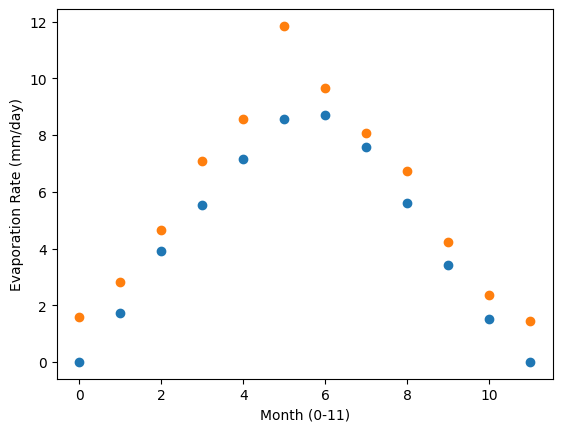

In [ ]:
plt.xlabel("Month (0-11)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(pan_m_df["est"].to_numpy(), "o")
plt.plot(res_m_mean_df.to_numpy(), "o")

## Curve Fitting

Fitted Parameters:  [-1.47662493e-02  8.90701144e-04  1.71684167e-05  1.25947725e+00
 -1.15736015e+02 -1.52483809e+00  7.74772675e-01 -5.87612260e-05]


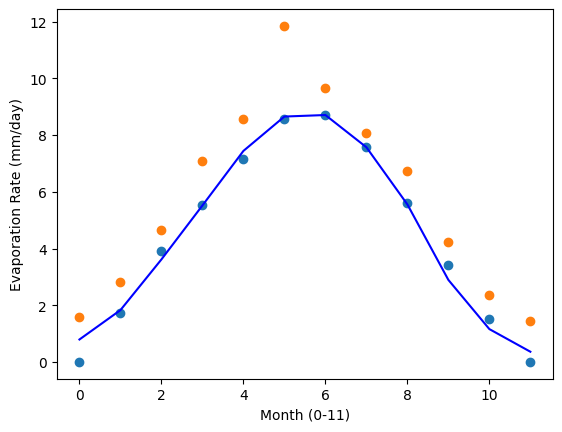

In [218]:
def get_evaporation_rate(
    mean_temp: float, dewp_temp: float, elev: float, solar_irr: float, wind_speed: float
) -> float:
    return (0.015 + 0.00042 * mean_temp + 10**-6 * elev) * (
        0.8 * solar_irr
        - 40
        + 2.5 * (1.0 - 8.7 * 10**-5 * elev) * wind_speed * (mean_temp - dewp_temp)
    )


def evaporation_rate_curve(
    X: np.ndarray,
    # Output/fitting variables (unknown)
    c1: float = 0.015,
    c2: float = 0.00042,
    c3: float = 10e-6,
    c4: float = 0.8,
    c5: float = -40,
    c6: float = 2.5,
    c7: float = 1.0,
    c8: float = 8.7 * 10**-5,
) -> float:
    mean_temp, dewp_temp, solar_irr, wind_speed = X.T

    return (c1 + c2 * mean_temp + c3 * ELEVATION) * (
        c4 * solar_irr
        + c5
        + c6 * (c7 - c8 * ELEVATION) * wind_speed * (mean_temp - dewp_temp)
    )


res_m_data = (
    res_m_df.groupby("month").mean()[["tmpc", "dwpc", "G(i)", "smps"]].to_numpy()
)
pan_m_evap = pan_m_df.est.to_numpy()

popt, pcov = curve_fit(
    evaporation_rate_curve,
    res_m_data,
    pan_m_evap,
    p0=[
        0.015,
        0.00042,
        10e-6,
        0.8,
        -40,
        2.5,
        1.0,
        8.7 * 10**-5,
    ],  # Seeding parameters from reference
)

print("Fitted Parameters: ", popt)
plt.xlabel("Month (0-11)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(pan_m_df["est"].to_numpy(), "o")  # Pan estimations
plt.plot(res_m_mean_df.to_numpy(), "o")  # Model predictions
plt.plot(
    pan_m_df["month"].to_numpy() - 1, evaporation_rate_curve(res_m_data, *popt), "b"
)

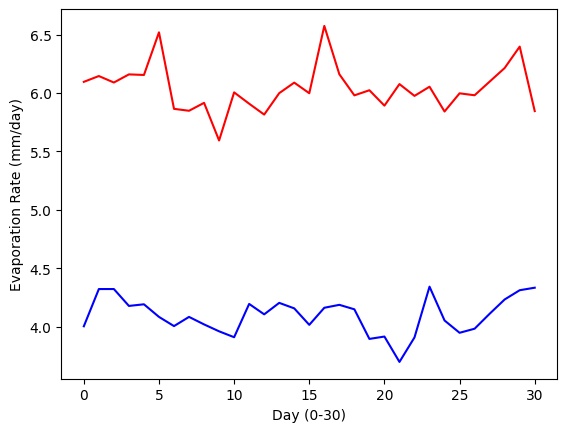

In [ ]:
pga_d_df = get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "D")
irr_d_df = get_mean(irr_df, "time", ["G(i)"], "D")

res_d_df = pd.merge(
    pga_d_df,
    irr_d_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

res_d_df["est"] = res_d_df.apply(
    lambda row: get_evaporation_rate(
        row["tmpc"], row["dwpc"], ELEVATION, row["G(i)"], row["smps"]
    ),
    axis=1,
)

res_d_mean_df = res_d_df["est"].groupby(res_d_df["month"]).mean()
res_d_data = res_d_df.groupby("day").mean()[["tmpc", "dwpc", "G(i)", "smps"]].to_numpy()
days = np.arange(res_d_data.shape[0])

plt.xlabel("Day (0-30)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(days, evaporation_rate_curve(res_d_data, *popt), "b")  # Curve-fitted model
plt.plot(days, res_d_df["est"].groupby(res_d_df["day"]).mean(), "r")  # Original model